# Optimizing the KSD

In [1]:
%load_ext autoreload

from jax import config
config.update("jax_debug_nans", True)
# config.update("jax_log_compiles", True)
# config.update("jax_disable_jit", True)

import sys
import os
sys.path.append("/home/lauro/code/msc-thesis/svgd/kernel_learning/")
import json_tricks as json
import copy
from functools import partial

from tqdm import tqdm
import jax.numpy as np
from jax import grad, jit, vmap, random, lax, jacfwd, value_and_grad
from jax import lax
from jax.ops import index_update, index
import matplotlib.pyplot as plt
import numpy as onp
import jax
import pandas as pd
import haiku as hk
from jax.experimental import optimizers

import config

import utils
import metrics
import time
import plot
import stein
import kernels
import distributions
import nets
import models
# import old_models

from jax.experimental import optimizers

key = random.PRNGKey(0)

/home/lauro/.virtualenvs/msc-thesis/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [2]:
@partial(jit, static_argnums=1)
def get_sd(samples, fun):
    return stein.stein_discrepancy(samples, target.logpdf, fun)

### Parameters

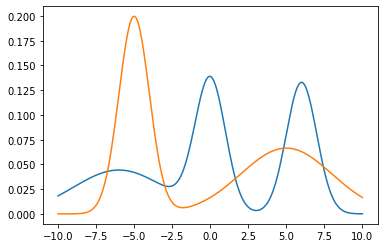

In [11]:
setup = distributions.double_mixture
setup.plot(lims=(-10, 10))
target, proposal = setup.get()
# sizes = [16, 16, 3]
sizes = None

In [12]:
def get_ksds(kernel):
    """Return 100 ksds between prop and target"""
    @jit
    def compute_ksd(samples):
        return stein.ksd_squared_u(samples, target.logpdf, kernel)
    ksds_squared = []
    for _ in tqdm(range(100)):
        samples = proposal.sample(400)
        ksds_squared.append(compute_ksd(samples))
    ksds = onp.sqrt(onp.clip(ksds_squared, a_min=0, a_max=None))
    return ksds

# Train

In [24]:
%autoreload

In [25]:
learning_rate = 1e-2 
batch_size = 50
learner = models.KernelLearner(target,
                               key=key,
                               sizes=sizes,
                               learning_rate=learning_rate)
# samples = proposal.sample(1000)
# kernel = learner.get_kernel(samples)
# ksds_pre = get_ksds(kernel)

In [26]:
samples = proposal.sample(batch_size)
learner.step(samples, samples)

In [27]:
key, subkey = random.split(key)
val_x = proposal.sample(40)
def next_batch(key):
    train_x = proposal.sample(batch_size, key=key)
    return train_x, val_x
learner.train(next_batch, subkey, n_steps=10, progress_bar=True)

100%|██████████| 10/10 [00:03<00:00,  3.23it/s]


In [28]:
paramtree = utils.dict_concatenate(learner.rundata["model_params"])

leaves, structure = jax.tree_flatten(paramtree)

h = np.array(leaves[0])
s = np.array(leaves[1])

%matplotlib inline
plt.plot(h, "--.", label="bandwidth")
plt.plot(s, "--.")
plt.legend()

In [41]:
# ksds_post = get_ksds(proposal, learner.get_kernel(learner.get_params()))

inducing_samples = proposal.sample(500)
learned_phistar = utils.negative(learner.get_field(inducing_samples))
def optimal_phistar(x):
    div = 2*learner.lambda_reg
    return grad(lambda x: target.logpdf(x) - proposal.logpdf(x))(x) / div
phistar_rbf = stein.get_phistar(kernels.get_rbf_kernel(1), target.logpdf, inducing_samples)

# compute optimal KSD
sds = []
for _ in range(100):
    samples = proposal.sample(400)
    sds.append(get_sd(samples, optimal_phistar))

Plot results:


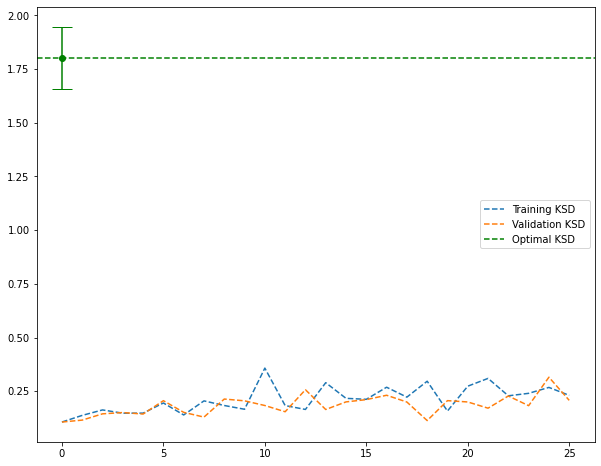

In [42]:
print("Plot results:")

rundata = learner.rundata
fig, ax = plt.subplots(figsize=[10,8])
plt.plot(rundata["training_ksd"], "--", label="Training KSD")
plt.plot(rundata["validation_ksd"], "--", label="Validation KSD")
plt.errorbar(x=0, y=onp.mean(sds), yerr=onp.std(sds), fmt="o", capsize=10, color="green")
plt.axhline(y=onp.mean(sds), linestyle="--", label="Optimal KSD", color="green")
plt.legend()

### plot learned stein gradient

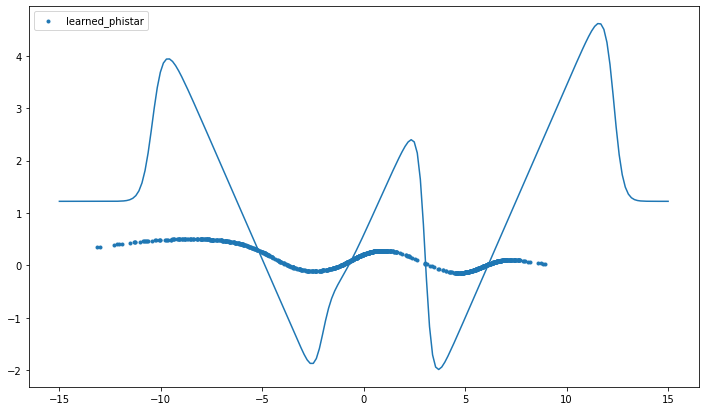

In [43]:
grid_n = 1000
grid = np.linspace(-15, 15, grid_n).reshape(grid_n, 1)
grid = proposal.sample(1000)
fig, ax = plt.subplots(figsize=[12,7])
plt.scatter(grid, vmap(learned_phistar)(grid), marker=".", label="learned_phistar")

def opt_g(x):
    return -setup.grad_kl(x) / (2*learner.lambda_reg)
plot.plot_fun(opt_g, lims=(-15, 15))

plt.legend()

### optimal KSD

In [44]:
get_sd(samples, learned_phistar)

DeviceArray(0.29667893, dtype=float32)

## plot learned kernel

In [45]:
learned_kernel = learner.get_kernel(samples)

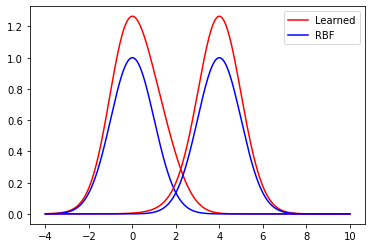

In [46]:
ngrid = 10**4
grid = np.linspace(-4, 10, ngrid).reshape(ngrid,1)
x = np.array([0.])
plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), label="Learned", color="r")
plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), label="RBF", color="b")
x = np.array([4.])
plt.plot(grid, vmap(learned_kernel, (0, None))(grid, x), color="r")
plt.plot(grid, vmap(kernels.get_rbf_kernel(1),  (0, None))(grid, x), color="b")

plt.legend()